In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [2]:
# Necessary for loading data and modeling in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [35]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 150

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'RELATIONAL' : {'cond':['match','relation']}
}

In [36]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [61]:
with open('/content/hcp_task/subjects_list.txt', 'r') as f:
  lines = str(f.readline()).split(' ')




len(lines)

100

In [59]:
lines

['100307 100408 101915 102816 103414 103515 103818 105115 105216 106016 106319 110411 111009 111312 111514 111716 113215 113619 114924 115320 117122 117324 118730 118932 119833 120111 120212 122317 123117 124422 125525 126325 127933 128632 129028 130013 130316 130922 131924 133625 133827 133928 134324 135932 136833 137128 138231 138534 139637 140824 142828 143325 148032 148335 149337 149539 150524 151223 151526 151627 153025 153429 154431 156233 156637 157336 158035 158540 159239 159340 160123 161731 162329 162733 163129 163432 167743 172332 175439 176542 178950 182739 185139 188347 189450 190031 192439 192540 193239 194140 196144 196750 197550 198451 199150 199655 200614 201111 201414 205119\n']

In [37]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



In [38]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [39]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  taskey = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{taskey}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [40]:
my_exp = 'RELATIONAL'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 232)


In [41]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [42]:
my_exp = 'RELATIONAL'
my_regions = [*range(360)]

In [43]:
HCP_DATA_FRAME = pd.read_excel("/content/HCP Behavioral 2.0.xlsx")

In [44]:
new_df = HCP_DATA_FRAME[['Subject','Age', 'Gender', 'PMAT24_A_CR']]
new_df.to_csv("HCP_DATA_FILTERED.csv", index = False)

In [81]:
new_df['Age'].unique()

array(['26-30', '31-35', '22-25', '36+'], dtype=object)

In [82]:
def transform_group(age):
    if age == '22-25':
        return 1

    if age == '26-30':
        return 2

    if age == '31-35':
        return 3

    if age == '36+':
        return 4



### Visualize some of the data

(360, 232)
[[array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58]), array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106]), array([158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180])], [array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33]), array([110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132]), array([184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 200, 201, 202, 203, 204, 205, 206])]]
2
3
(360, 23)


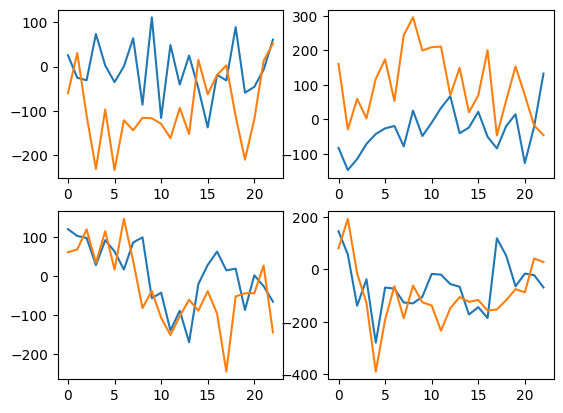

In [46]:
print(data.shape)
print(evs)
print(len(evs))
print(len(evs[0]))

print(data[:,evs[0][0]].shape)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(data[[164, 344],:][:,evs[0][0]].T)
axs[0, 1].plot(data[[164, 344],:][:,evs[0][1]].T)
axs[1, 0].plot(data[[164, 344],:][:,evs[1][0]].T)
axs[1, 1].plot(data[[164, 344],:][:,evs[1][1]].T)
plt.show()

In [83]:
def load_data(my_exp , my_regions):

  HCP_data_frame = pd.read_csv("HCP_DATA_FILTERED.csv")
  HCP_data_frame['age_group'] = HCP_data_frame['Age'].apply(transform_group)

  steps = int(10/TR+.5)    # calculating stpes for 10 seconds

  # las ROI's
  timeseries_list = []
  # relmatch
  relmatch_list = [] # relation or match

  # age
  age_list = []
  # IQ
  fluid_intelligence_list = []
  # gender
  Gender_list = []

  order = torch.randperm(100).numpy()
  for i in order:     # subject
    for r in range(2):     # run

      data = load_single_timeseries(subject=subjects[i],
                                    experiment=my_exp,
                                    run=r,
                                    remove_mean=True)

      # Normalizing data by subject
      timeseries = (data - data.mean()) / data.std()

      # get the evs plus 10 seconds of the time series before and after (14 steps for tr=.76)
      evs = load_evs(subject=subjects[i], experiment=my_exp, run=r)

      for c in range(2):   # condition
        for t in range(2): # block
          evs_index = np.hstack((
            np.arange(evs[c][t][0]-steps,evs[c][t][0]),
            np.array(evs[c][t]),
            np.arange((evs[c][t][-1]+1),(evs[c][t][-1]+1+steps))
          ))

          # (N, L, H_in)

          timeseries_list.append(timeseries[my_regions,:][:,evs_index].T)
          relmatch_list.append(c)
          ## control variables
          filtered = HCP_data_frame[HCP_data_frame['Subject'] == int(subjects[i])]
          if len(filtered) > 0:
            age_list.append(HCP_data_frame[HCP_data_frame['Subject']==int(subjects[i])]['age_group'])
            fluid_intelligence_list.append(HCP_data_frame[HCP_data_frame['Subject']==int(subjects[i])]['PMAT24_A_CR'])
            Gender_list.append(1 if HCP_data_frame[HCP_data_frame['Subject']==int(subjects[i])]['Gender'].item()=='F' else 0)
          # else:
          #   age_list.append(None)
          #   fluid_intelligence_list.append(None)
          #   Gender_list.append(None)


  #print(age_list)
  return (
      torch.tensor(np.array(timeseries_list)),
      torch.tensor(np.array(relmatch_list)),
      torch.tensor(np.array(age_list)),#.squeeze(1),
      torch.tensor(np.array(fluid_intelligence_list)).squeeze(1),
      torch.tensor(np.array(Gender_list))
  )

In [84]:
experiment='RELATIONAL'
regions = [*range(360)]
X = load_data(experiment, regions)

In [91]:
X[4]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [50]:
i = 0
HCP_data_frame = HCP_DATA_FRAME
print(HCP_data_frame[HCP_data_frame['Subject'] == subjects[i]])

Empty DataFrame
Columns: [Subject, Release, Acquisition, Gender, Age, 3T_Full_MR_Compl, T1_Count, T2_Count, 3T_RS-fMRI_Count, 3T_RS-fMRI_PctCompl, 3T_Full_Task_fMRI, 3T_tMRI_PctCompl, fMRI_WM_PctCompl, fMRI_Gamb_PctCompl, fMRI_Mot_PctCompl, fMRI_Lang_PctCompl, fMRI_Soc_PctCompl, fMRI_Rel_PctCompl, fMRI_Emo_PctCompl, 3T_dMRI_Compl, 3T_dMRI_PctCompl, dMRI_3T_ReconVrs, fMRI_3T_ReconVrs, 7T_Full_MR_Compl, 7T_RS-fMRI_Count, 7T_RS-fMRI_PctCompl, 7T_Full_Task_fMRI, 7T_tMRI_PctCompl, fMRI_Movie_Compl, fMRI_Movie_PctCompl, fMRI_Ret_Compl, fMRI_Ret_PctCompl, 7T_dMRI_Compl, 7T_dMRI_PctCompl, 7T_fMRI_Mov_Vrs, MEG_AnyData, MEG_FullProt_Compl, MEG_HeadModel_Avail, MEG_CortRibn_Avail, MEG_Anatomy_Avail, MEG_Anatomy_Compl, MEG_Noise_Avail, MEG_Noise_Compl, MEG_RS_Avail, MEG_RS_Compl, MEG_WM_Avail, MEG_WM_Compl, MEG_StoryMath_Avail, MEG_StoryMath_Compl, MEG_Motor_Avail, MEG_Motor_Compl, Non-TB_Compl, VisProc_Compl, DelDisc_Compl, SCPT_Compl, IWRD_Compl, PMAT_Compl, VSPLOT_Compl, EmoRecog_Compl, NEO-FFI

In [ ]:
HCP_DATA_FRAME['Subject']

0      100206
1      100610
2      101006
3      101309
4      101915
        ...  
334    966975
335    984472
336    987983
337    993675
338    994273
Name: Subject, Length: 339, dtype: int64

In [34]:
type(X[0].shape)

torch.Size

In [68]:
labels =

,Subject,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
0,100206,S900,Q11,M,26-30,True,1,1,4,100,...,6.0,108.79,97.19,1.0,49.7,72.63,72.03,1.84,0.0,1.84
1,100610,S900,Q08,M,26-30,True,2,1,4,100,...,2.0,122.25,110.45,0.0,38.6,84.84,85.31,1.92,1.0,1.88
2,101006,S500,Q06,F,31-35,True,2,2,4,100,...,6.0,122.25,111.41,0.0,38.6,123.80,123.31,1.80,0.0,1.80
3,101309,S500,Q06,M,26-30,True,1,1,4,100,...,5.2,122.25,110.45,0.0,38.6,106.39,104.39,1.80,0.0,1.80
4,101915,Q3,Q04,F,31-35,True,2,2,4,100,...,4.4,96.87,77.61,0.0,38.6,112.11,111.70,1.84,1.0,1.80


In [66]:
# Convert to NumPy and save
np.save("dataLSTM.npy", X[0].numpy())

# Load and convert back to PyTorch tensor
loaded_tensor = torch.tensor(np.load("dataLSTM.npy"))


In [67]:
loaded_tensor.shape

torch.Size([800, 51, 360])

In [92]:
# Convert to NumPy and save
np.save("rel_match_label.npy", X[1].numpy())

# Load and convert back to PyTorch tensor
label1 = torch.tensor(np.load("rel_match_label.npy"))

In [94]:
label1.shape

torch.Size([800])

Hacemos los labels un dataframe

In [96]:

import pandas as pd


# Stack the tensors into a single 2D tensor
data = torch.stack([X[2].squeeze(), X[3], X[4]], dim=1)

# Convert to a Pandas DataFrame
df = pd.DataFrame(data.numpy(), columns=["age_group", "PMAT24_A_CR", "Gender"])



In [97]:
df

,age_group,PMAT24_A_CR,Gender
0,3.0,18.0,1.0
1,3.0,18.0,1.0
2,3.0,18.0,1.0
3,3.0,18.0,1.0
4,3.0,18.0,1.0
...,...,...,...
275,3.0,14.0,1.0
276,3.0,14.0,1.0
277,3.0,14.0,1.0
278,3.0,14.0,1.0


In [98]:
# Save to CSV
df.to_csv("labels.csv", index=False)